The main goal of this project is to develop and evaluate a trading agent using reinforcement learning techniques. The agent will learn to make trading decisions based on market data to maximize its profit while managing risk.

We use a specific type of RL algorithm , SARSA (State-Action-Reward-State-Action). 
The agent interacts with a simulated trading environment, making decisions on whether to buy, sell, shortsell or hold assets based on the current market state.

The agent makes trading decisions based on market volatility and expected rate of return.
Volatility: The agent considers how much the price of an asset fluctuates. High volatility might indicate a high-risk, high-reward situation.
Expected Rate of Return: The agent estimates the potential profit from a trade. It aims to make trades that have a high expected return relative to the risk.

Results:

when we predicted the volatility using LSTM but in Reinforcement Learning part
The Agent have small profit and the success rate is low, the agent is not able to make profitable trades consistently.

The team members that make up our team: 

Mojtaba Darvishzadeh,   
Saman Dadkhah,  
Zhaleh Keshavarzi,  



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from statsmodels.tsa.stattools import adfuller
# from sklearn.preprocessing import MinMaxScaler
# import tensorflow as tf
# from keras import Sequential
# from keras.src.layers import LSTM, Dense

In [3]:
train_df = pd.read_csv('data/IVV_1m_training.csv')
validation_df = pd.read_csv('data/IVV_1m_validation.csv')

In [4]:
# Convert the 'DateTime' column to a datetime object
train_df['DateTime'] = pd.to_datetime(train_df['DateTime'])
train_df= train_df.set_index('DateTime')

validation_df['DateTime'] = pd.to_datetime(validation_df['DateTime'])
validation_df = validation_df.set_index('DateTime')

train_df.index = train_df.index.tz_localize(None)
validation_df.index = validation_df.index.tz_localize(None)

In [6]:
# Resample the data to 5-minute intervals
train_df = train_df.resample('5min').agg({
     'Low': 'min',
     'Volume': 'sum',
     'Open': 'first',
     'High': 'max',
     'Close': 'last'
})

validation_df = validation_df.resample('5min').agg({
     'Low': 'min',
     'Volume': 'sum',
     'Open': 'first',
     'High': 'max',
    'Close': 'last'
})



In [7]:
# train_df = train_df.tail(100000)

In [8]:
# Check Volume column for ensuring it is numeric
train_df['Volume'] = pd.to_numeric(train_df['Volume'], errors='coerce')  
validation_df['Volume'] = pd.to_numeric(validation_df['Volume'], errors='coerce') 

# Calculate the Exponential Moving Average (EMA) for the Close price
train_df['EMA15'] = train_df['Close'].ewm(span=20, adjust=False).mean()
validation_df['EMA15'] = validation_df['Close'].ewm(span=20, adjust=False).mean()

# Calculate Bollinger Bands
def bollinger_bands(data, window=15):
    sma = data['Close'].rolling(window=window).mean()
    rstd = data['Close'].rolling(window=window).std()
    upper_band = sma + 2 * rstd
    lower_band = sma - 2 * rstd
    return upper_band, lower_band

train_df['Upper_Band'], train_df['Lower_Band'] = bollinger_bands(train_df)
validation_df['Upper_Band'], validation_df['Lower_Band'] = bollinger_bands(validation_df)

# Calculate log returns
train_df['Log_Return'] = np.log(train_df['Close'] / train_df['Close'].shift(1))
validation_df['Log_Return'] = np.log(validation_df['Close'] / validation_df['Close'].shift(1))

# Calculate rolling volatility
volatility_window_size = 15
train_df['Volatility'] = train_df['Log_Return'].ewm(span=volatility_window_size).std()
validation_df['Volatility'] = validation_df['Log_Return'].ewm(span=volatility_window_size).std()

# Calculate expected return
ERR_window_size = 10  # Adjust the window size as needed
train_df['Expected_Return'] = train_df['Log_Return'].rolling(window=ERR_window_size).mean()
validation_df['Expected_Return'] = validation_df['Log_Return'].rolling(window=ERR_window_size).mean()

In [9]:
train_df = train_df.dropna()
validation_df = validation_df.dropna()

rl_train_df = train_df
rl_val_df = validation_df

In [10]:
if train_df.isnull().any().any():
    print("There are NaN values in train_df")
else:
    print("There are no NaN values in train_df")

if validation_df.isnull().any().any():
    print("There are NaN values in validation_df")
else:
    print("There are no NaN values in validation_df")

There are no NaN values in train_df
There are no NaN values in validation_df


In [11]:
train_df.head()
train_df.shape

(160360, 11)

In [12]:
# Data preprocessing
def prepare_data(df, past_steps, future_step):
    X, y, timestamps = [], [], []
    for i in range(past_steps, len(df) - future_step + 1):
        X.append(df.iloc[i - past_steps:i].values)  # Gather past records up to the current point
        y.append(df.iloc[i + future_step - 1]['Volatility'])  # Future volatility to be predicted
        timestamps.append(df.index[i + future_step - 1])
    return np.array(X), np.array(y), np.array(timestamps)


In [13]:
features = ['Close', 'Low', 'Open','High','EMA15','Upper_Band','Lower_Band','Expected_Return','Volatility'] # 
train_features = train_df[features]
validation_features = validation_df[features]

In [14]:
# Normalize the features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_features_scaled = scaler.fit_transform(train_features)
validation_features_scaled = scaler.transform(validation_features)

In [15]:
# Convert scaled data back to DataFrame for easier handling
train_features_scaled_df = pd.DataFrame(train_features_scaled, columns=features, index=train_features.index)
validation_features_scaled_df = pd.DataFrame(validation_features_scaled, columns=features, index=validation_features.index)

In [16]:
# Prepare the training and validation data
past_steps = 30
future_step = 3
X_train, y_train, train_timestamp = prepare_data(train_features_scaled_df, past_steps, future_step)
X_validation, y_validation,validation_timestamps = prepare_data(validation_features_scaled_df, past_steps, future_step)

In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from keras.src.callbacks import EarlyStopping,LearningRateScheduler

ts = past_steps
nf = len(features)


# LSTM model
model = Sequential([
    layers.Input(shape=(ts, nf)),
    # First LSTM layer
    layers.LSTM(128, return_sequences=True, activation='tanh', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),  # Adjusted dropout rate

    # Second LSTM layer
    layers.LSTM(64, return_sequences=False, activation='tanh'),
    layers.Dropout(0.3),  # Adjusted dropout rate

    layers.Dense(32, activation='relu'),  # New Dense layer for added complexity

    layers.Dense(1)
])

# Learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

# Compile the model
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(scheduler)

# Model training
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                    batch_size=1024, epochs=50, callbacks=[early_stopping, lr_scheduler])

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - loss: 0.0078 - mean_absolute_error: 0.0172 - val_loss: 0.0025 - val_mean_absolute_error: 0.0090 - learning_rate: 0.0010
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 157ms/step - loss: 0.0018 - mean_absolute_error: 0.0114 - val_loss: 0.0012 - val_mean_absolute_error: 0.0091 - learning_rate: 0.0010
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 175ms/step - loss: 9.7174e-04 - mean_absolute_error: 0.0109 - val_loss: 6.3299e-04 - val_mean_absolute_error: 0.0099 - learning_rate: 0.0010
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 198ms/step - loss: 6.5682e-04 - mean_absolute_error: 0.0113 - val_loss: 4.2653e-04 - val_mean_absolute_error: 0.0091 - learning_rate: 0.0010
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 212ms/step - loss: 4.5933e-04 - mean_absolute_error: 0.0105 - val_loss: 3.3261e-04 - val_mean_absolute_error: 0.0089 - learning_rate: 0.0010
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 222ms/step - loss: 3.8145e-04 - mean_absolute_e

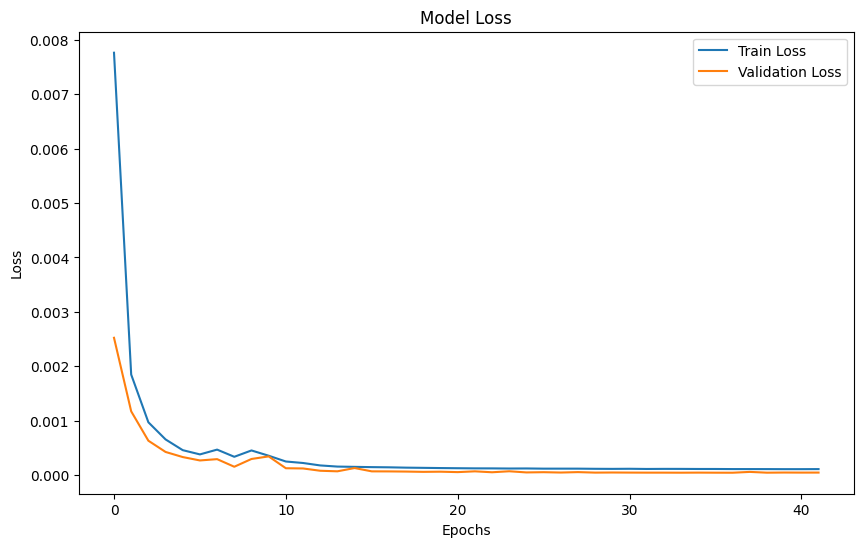

In [18]:
# Plotting the training and validation loss
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Train Loss')
plt.plot(val_loss , label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

In [19]:
# Predicting the volatility for the validation data and training data
predicted_prices = model.predict(X_validation)
predicted_train = model.predict(X_train)

1498/1498 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step
5011/5011 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step


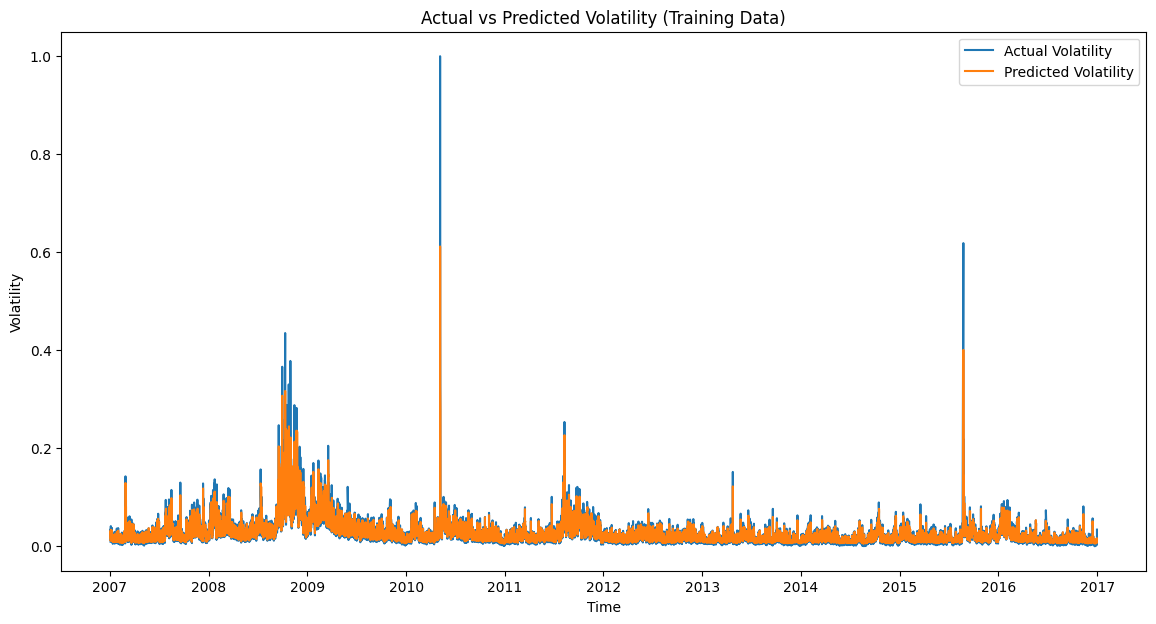

In [20]:
# Plotting the actual vs predicted volatility for the training data
plt.figure(figsize=(14, 7))
plt.plot(train_timestamp, y_train, label='Actual Volatility')
plt.plot(train_timestamp, predicted_train, label='Predicted Volatility')
plt.title('Actual vs Predicted Volatility (Training Data)')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

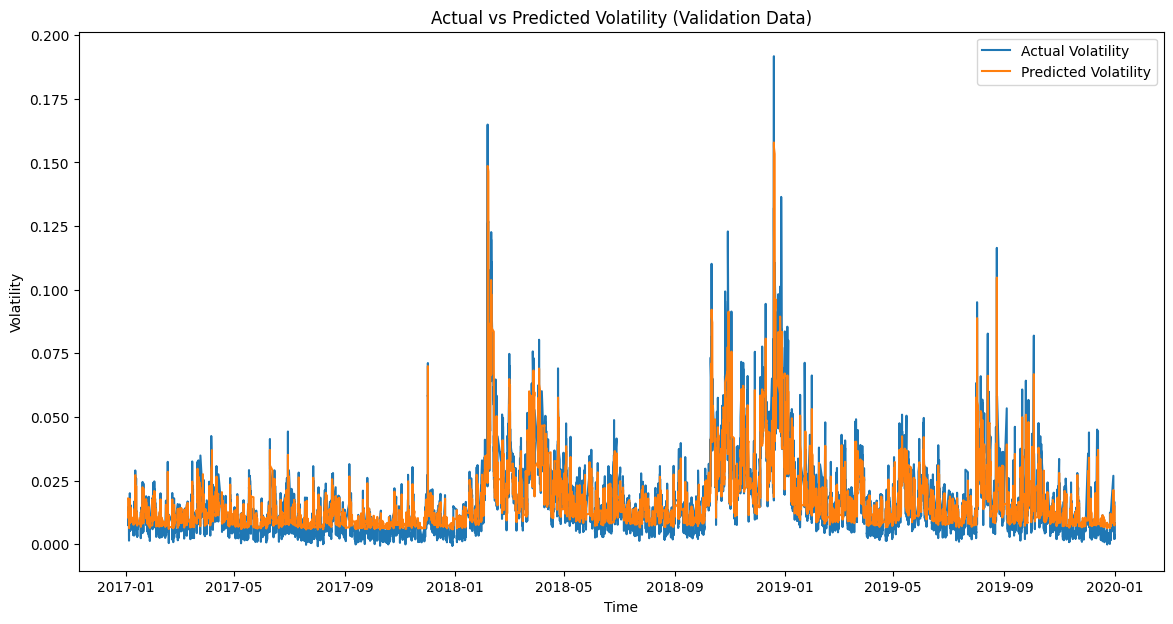

In [21]:
# Plotting the actual vs predicted volatility for the validation data
plt.figure(figsize=(14, 7))
plt.plot(validation_timestamps, y_validation, label='Actual Volatility')
plt.plot(validation_timestamps, predicted_prices, label='Predicted Volatility')
plt.title('Actual vs Predicted Volatility (Validation Data)')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Trading Environment

In [25]:
import gymnasium as gym
from gym import spaces
import numpy as np
import random
from collections import defaultdict

# Trading environment class
class TradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000, trading_cost=0.001, max_trades_per_day=8,
                 holding_cost_factor=0.0001, risk_aversion=0.4, momentum_reward_factor=0.05,
                 bollinger_breakout_reward=0.2):
        super(TradingEnv, self).__init__()

        self.data = data
        self.initial_balance = initial_balance
        self.trading_cost = trading_cost
        self.max_trades_per_day = max_trades_per_day
        self.holding_cost_factor = holding_cost_factor
        self.risk_aversion = risk_aversion
        self.momentum_reward_factor = momentum_reward_factor
        self.bollinger_breakout_reward = bollinger_breakout_reward
        self.current_step = 0
        self.position = 0

        # Action space: 0: Hold, 1: Buy, 2: Sell
        self.action_space = spaces.Discrete(3)  # Removed Short Sell
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(8,), dtype=np.float32)

        self.reset()

    def reset(self):
        self.balance = self.initial_balance
        self.holdings = 0
        self.short_holdings = 0  # Removed short_holdings
        self.current_step = np.random.randint(0, len(self.data) - 200)
        self.trades = 0
        self.total_profit = 0
        self.successful_trades = 0
        self.done = False
        self.position = 0
        self.trades_today = 0
        self.holding_duration = 0
        self.portfolio_values = [self.initial_balance]
        self.previous_peak = self.initial_balance
        self.max_drawdown = 0
        self.returns = []
        self.benchmark_returns = []

        return self._next_observation(0)

    def _calculate_profit(self, action, current_price):
        if action == 2:  # Sell
            profit = current_price - self.data.iloc[self.current_step - 1]['Close']
        else:
            profit = 0
        return profit

    def _next_observation(self, reward):
        current_price = self.data.iloc[self.current_step]['Close']
        ema15 = self.data.iloc[self.current_step]['EMA15']
        upper_band = self.data.iloc[self.current_step]['Upper_Band']
        lower_band = self.data.iloc[self.current_step]['Lower_Band']
        volatility = self.data.iloc[self.current_step]['Volatility']
        expected_return = self.data.iloc[self.current_step]['Expected_Return']
        volume = self.data.iloc[self.current_step]['Volume']

        observation = (
            current_price,
            ema15,
            upper_band,
            lower_band,
            volatility,
            expected_return,
            volume,
            self.position
        )
        # scale the reward
        max_reward = 10
        min_reward = -1
        scaled_reward = (reward - min_reward) / (max_reward - min_reward)

        return observation, scaled_reward

    def step(self, action):
        if self.done:
            return self._next_observation(0), 0, self.done, {}

        current_price = self.data.iloc[self.current_step]['Close']
        expected_return = self.data.iloc[self.current_step]['Expected_Return']
        predicted_volatility = self.data.iloc[self.current_step]['Volatility']
        volume = self.data.iloc[self.current_step]['Volume']
        reward = 0

        holding_cost = self.holding_cost_factor * self.holding_duration * self.holdings  
        self.balance -= holding_cost

        if action == 1:  # Buy
            if self.balance > current_price * (1 + self.trading_cost) and self.trades_today < self.max_trades_per_day:
                self.holdings += 1
                trade_cost = current_price * self.trading_cost
                self.balance -= current_price + trade_cost
                self.trades += 1
                self.trades_today += 1
                self.position = 1
                self.holding_duration = 0
                reward = (expected_return / predicted_volatility) * (1 - self.risk_aversion) * expected_return - trade_cost
                if current_price > self.data.iloc[self.current_step - 1]['Close']:
                    reward += self.momentum_reward_factor * volume
                if current_price > self.data.iloc[self.current_step]['Upper_Band']:
                    reward += self.bollinger_breakout_reward * volume
            else:
                reward = -0.1

        elif action == 2:  # Sell
            if self.holdings > 0 and self.trades_today < self.max_trades_per_day:
                self.holdings -= 1
                trade_cost = current_price * self.trading_cost
                self.balance += current_price - trade_cost
                self.trades += 1
                self.trades_today += 1
                profit = current_price - self.data.iloc[self.current_step - 1]['Close']
                self.total_profit += profit
                if profit > 0:
                    self.successful_trades += 1
                reward = profit - self.holding_cost_factor * self.holding_duration - trade_cost
                if current_price < self.data.iloc[self.current_step - 1]['Close']:
                    reward += self.momentum_reward_factor * volume
                if current_price < self.data.iloc[self.current_step]['Lower_Band']:
                    reward += self.bollinger_breakout_reward * volume
            else:
                reward = -0.1

        elif action == 0:  # Hold
            self.holding_duration += 1
            reward = (expected_return / predicted_volatility) * (1 - self.risk_aversion) * expected_return - self.holding_cost_factor * self.holding_duration

        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            self.done = True
        elif self.data.index[self.current_step].date() != self.data.index[self.current_step - 1].date():
            self.trades_today = 0
            self.holding_duration = 0

        self.portfolio_values.append(self.balance + self.holdings * self.data.iloc[self.current_step]['Close'])  
        self.previous_peak = max(self.previous_peak, self.portfolio_values[-1])
        current_drawdown = (self.previous_peak - self.portfolio_values[-1]) / self.previous_peak
        self.max_drawdown = max(self.max_drawdown, current_drawdown)

        if len(self.portfolio_values) > 1:
            daily_return = (self.portfolio_values[-1] - self.portfolio_values[-2]) / self.portfolio_values[-2]
            self.returns.append(daily_return)

        benchmark_return = (self.data.iloc[self.current_step]['Close'] - self.data.iloc[self.current_step - 1]['Close']) / self.data.iloc[self.current_step - 1]['Close']
        self.benchmark_returns.append(benchmark_return)

        observation, scaled_reward = self._next_observation(reward)

        return observation, scaled_reward, self.done, {'drawdown': self.max_drawdown, 'returns': self.returns, 'benchmark_returns': self.benchmark_returns}

    def render(self, mode='human', close=False):
        profit = self.balance + self.holdings * self.data.iloc[self.current_step]['Close'] - self.initial_balance
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(f'Holdings: {self.holdings}')
        print(f'Profit: {profit}')

# SARSA Agent

In [26]:
# SARSA Agent class
class SarsaAgent:
    def __init__(self, action_space, learning_rate=0.01, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, learning_rate_decay=0.999, memory_size=1000):
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.learning_rate_decay = learning_rate_decay

        # Adjust Q-table size to match the new action space
        self.q_table = defaultdict(lambda: np.zeros(action_space.n))  
        self.memory = []
        self.memory_size = memory_size

    def choose_action(self, state) -> int:
        state_tuple = tuple(state)
        if random.uniform(0, 1) < self.epsilon:
            return self.action_space.sample()
        else:
            return np.argmax(self.q_table[state_tuple])

    def update_q_table(self, state, action, reward, next_state, next_action):
        state_tuple = tuple(state)
        next_state_tuple = tuple(next_state)
        td_target = reward + self.discount_factor * self.q_table[next_state_tuple][next_action]
        td_error = td_target - self.q_table[state_tuple][action]
        self.q_table[state_tuple][action] += self.learning_rate * td_error
        self.learning_rate *= self.learning_rate_decay

    def replay_experience(self):
        if len(self.memory) > 0:
            batch_size = 32
            batch = random.sample(self.memory, batch_size)
            for s, a, r, ns, d in batch:
                ns_tuple = tuple(ns)
                na = self.choose_action(ns_tuple)
                self.update_q_table(s, a, r, ns_tuple, na)

    def decay_epsilon(self):
        self.epsilon *= self.epsilon_decay

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.memory_size:
            self.memory.pop(0)



# Training the SARSA Agent

In [27]:
import numpy as np


env = TradingEnv(rl_train_df.tail(16000))
agent = SarsaAgent(env.action_space)

total_episodes = 100

# Function to calculate Sharpe Ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0):
    excess_returns = np.array(returns) - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns) if np.std(excess_returns) != 0 else 0

# Function to calculate max drawdown
def calculate_max_drawdown(returns):
    cumulative_returns = np.cumsum(returns)
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (peak - cumulative_returns) / peak
    max_drawdown = np.max(drawdown)
    return max_drawdown

# Initialize lists to store metrics for all episodes
all_returns = []
all_profits = []
all_trades = []
all_success_rates = []
all_drawdowns = []
all_sharpe_ratios = []

# Training loop
for episode in range(total_episodes):
    state = env.reset()
    action = agent.choose_action(state)
    done = False

    episode_returns = []

    while not done:
        next_state, reward, done, info = env.step(action)
        next_action = agent.choose_action(next_state)
        agent.update_q_table(state, action, reward, next_state, next_action)
        agent.store_experience(state, action, reward, next_state, done)
        state = next_state
        action = next_action

        episode_returns.append(reward)
        # env.render()
    agent.replay_experience()
    agent.decay_epsilon()

    # Calculate metrics for the episode
    total_reward = sum(episode_returns)
    trades = env.trades
    profit = env.total_profit
    success_rate = env.successful_trades / trades if trades > 0 else 0
    max_drawdown = calculate_max_drawdown(episode_returns)
    sharpe_ratio = calculate_sharpe_ratio(episode_returns)

    # Store metrics for later analysis
    all_returns.append(total_reward)
    all_profits.append(profit)
    all_trades.append(trades)
    all_success_rates.append(success_rate)
    all_drawdowns.append(max_drawdown)
    all_sharpe_ratios.append(sharpe_ratio)

    # Print metrics for the episode
    print(f"Episode: {episode+1}/{total_episodes}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.4f}, "
          f"Trades: {trades}, Profit: {profit:.2f}, Success Rate: {success_rate:.2f}, "
          f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Calculate final metrics over all episodes
final_total_reward = np.mean(all_returns)
final_profit = np.mean(all_profits)
final_trades = np.mean(all_trades)
final_success_rate = np.mean(all_success_rates)
final_max_drawdown = np.mean(all_drawdowns)
final_sharpe_ratio = np.mean(all_sharpe_ratios)

# Print final metrics
print("\nTraining completed.")
print(f"Final Average Total Reward: {final_total_reward:.2f}")
print(f"Final Average Trades: {final_trades:.2f}")
print(f"Final Average Profit: {final_profit:.2f}")
print(f"Final Average Success Rate: {final_success_rate:.2f}")
print(f"Final Average Max Drawdown: {final_max_drawdown:.2f}")
print(f"Final Average Sharpe Ratio: {final_sharpe_ratio:.2f}")


Episode: 1/100, Total Reward: 4850.17, Epsilon: 0.9950, Trades: 48, Profit: 0.60, Success Rate: 0.21, Sharpe Ratio: 0.15
Episode: 2/100, Total Reward: 170415.42, Epsilon: 0.9900, Trades: 1376, Profit: 3.90, Success Rate: 0.24, Sharpe Ratio: 0.11
Episode: 3/100, Total Reward: 136430.95, Epsilon: 0.9851, Trades: 1064, Profit: 2.94, Success Rate: 0.24, Sharpe Ratio: 0.08
Episode: 4/100, Total Reward: 145213.09, Epsilon: 0.9801, Trades: 1040, Profit: 2.49, Success Rate: 0.23, Sharpe Ratio: 0.10
Episode: 5/100, Total Reward: 203254.06, Epsilon: 0.9752, Trades: 1744, Profit: 10.45, Success Rate: 0.24, Sharpe Ratio: 0.11
Episode: 6/100, Total Reward: 44407.81, Epsilon: 0.9704, Trades: 400, Profit: 0.29, Success Rate: 0.23, Sharpe Ratio: 0.15
Episode: 7/100, Total Reward: 168056.87, Epsilon: 0.9655, Trades: 1456, Profit: -2.38, Success Rate: 0.24, Sharpe Ratio: 0.15
Episode: 8/100, Total Reward: 183273.04, Epsilon: 0.9607, Trades: 1536, Profit: 4.40, Success Rate: 0.24, Sharpe Ratio: 0.09
Epis

# Evaluation of the SARSA Agent

In [28]:

validation_env = TradingEnv(rl_val_df)
validation_agent = SarsaAgent(env.action_space)
# Evaluation function
def evaluate_agent(env, agent, num_episodes=100):
    all_returns = []
    all_profits = []
    all_trades = []
    all_success_rates = []
    all_drawdowns = []
    all_sharpe_ratios = []

    for episode in range(num_episodes):
        state = env.reset()
        action = agent.choose_action(state)
        done = False

        episode_returns = []

        while not done:
            next_state, reward, done, info = env.step(action)
            next_action = agent.choose_action(next_state)
            state = next_state
            action = next_action

            episode_returns.append(reward)
            # env.render()
        # Calculate metrics for the episode
        total_reward = sum(episode_returns)
        trades = env.trades
        profit = env.total_profit
        success_rate = env.successful_trades / trades if trades > 0 else 0
        max_drawdown = calculate_max_drawdown(episode_returns)
        sharpe_ratio = calculate_sharpe_ratio(episode_returns)

        # Store metrics for later analysis
        all_returns.append(total_reward)
        all_profits.append(profit)
        all_trades.append(trades)
        all_success_rates.append(success_rate)
        all_drawdowns.append(max_drawdown)
        all_sharpe_ratios.append(sharpe_ratio)

        # Print metrics for the episode
        print(f"Evaluation Episode: {episode+1}/{num_episodes}, Total Reward: {total_reward:.2f}, "
              f"Trades: {trades}, Profit: {profit:.2f}, Success Rate: {success_rate:.2f}, "
              f"Sharpe Ratio: {sharpe_ratio:.2f}")

    # Calculate final metrics over all episodes
    final_total_reward = np.mean(all_returns)
    final_profit = np.mean(all_profits)
    final_trades = np.mean(all_trades)
    final_success_rate = np.mean(all_success_rates)
    final_max_drawdown = np.mean(all_drawdowns)
    final_sharpe_ratio = np.mean(all_sharpe_ratios)

    # Print final metrics
    print("\nEvaluation completed.")
    print(f"Final Average Total Reward: {final_total_reward:.2f}")
    print(f"Final Average Trades: {final_trades:.2f}")
    print(f"Final Average Profit: {final_profit:.2f}")
    print(f"Final Average Success Rate: {final_success_rate:.2f}")
    print(f"Final Average Max Drawdown: {final_max_drawdown:.2f}")
    print(f"Final Average Sharpe Ratio: {final_sharpe_ratio:.2f}")

evaluate_agent(validation_env, validation_agent, num_episodes=100)


Evaluation Episode: 1/100, Total Reward: 447630.50, Trades: 3451, Profit: 2.94, Success Rate: 0.25, Sharpe Ratio: 0.11
Evaluation Episode: 2/100, Total Reward: 782942.30, Trades: 5928, Profit: -4.72, Success Rate: 0.25, Sharpe Ratio: 0.11
Evaluation Episode: 3/100, Total Reward: 738917.59, Trades: 5776, Profit: 30.44, Success Rate: 0.25, Sharpe Ratio: 0.11
Evaluation Episode: 4/100, Total Reward: 594787.38, Trades: 4148, Profit: 21.26, Success Rate: 0.25, Sharpe Ratio: 0.11
Evaluation Episode: 5/100, Total Reward: 357214.63, Trades: 2854, Profit: 56.40, Success Rate: 0.26, Sharpe Ratio: 0.11
Evaluation Episode: 6/100, Total Reward: 675590.44, Trades: 5248, Profit: 14.82, Success Rate: 0.25, Sharpe Ratio: 0.11
Evaluation Episode: 7/100, Total Reward: 351053.76, Trades: 2768, Profit: 23.58, Success Rate: 0.26, Sharpe Ratio: 0.12
Evaluation Episode: 8/100, Total Reward: 662751.88, Trades: 5248, Profit: 47.77, Success Rate: 0.25, Sharpe Ratio: 0.10
Evaluation Episode: 9/100, Total Reward: 